<a href="https://colab.research.google.com/github/dmitriygorlov/Yandex.Practikum_Data_Science/blob/main/Module-02_03-Machine-learning-in-business/project-7_machine-learning-in-business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выбор локации для скважины

Нужно решить, в каком из регионов бурить новую скважину .

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rnd_state = 42
# from scipy import stats as st

Читаем все нужные библиотеки и зафиксируем random_state

In [2]:
df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Прочли файлы, присутпим к их изучению

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Пропущенных значений по столбцам: id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
Дубликатов: 0.0


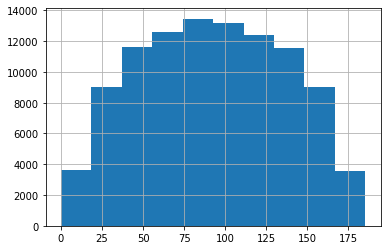

In [3]:
df0.info()
display(df0.head())
print('Пропущенных значений по столбцам:', df0.isna().mean())
print('Дубликатов:', df0.duplicated().mean())
df0['product'].hist()

**Регион 0** Таблица из 100 000 строчек. Для машинного обучения есть лишний признак id (технический номер скважины не должен влиять на запасы), нужно его выкинуть для моделей. Пропущенных значений нет, дубликатов нет. Данные в целевом признаке распределены нормально. Проверим и другие таблицы/регионы:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Пропущенных значений по столбцам: id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
Дубликатов: 0.0


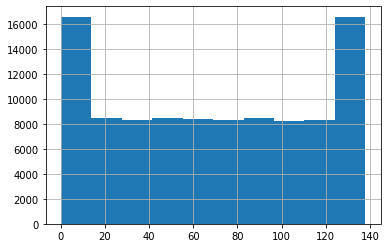

In [4]:
df1.info()
display(df1.head())
print('Пропущенных значений по столбцам:', df1.isna().mean())
print('Дубликатов:', df1.duplicated().mean())
df1['product'].hist()

**Регион 1** Таблица из 100 000 строчек, лишний признак id, пропущенных значений нет, дубликатов нет. Данные в целевом признаке распределены странно с большим выбросом около нуля и максимума. Посмотрим точнее.

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

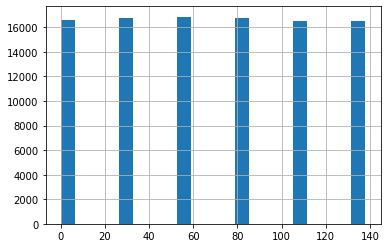

In [5]:
df1['product'].hist(bins = 21)
df1['product'].value_counts()

**Регион 1** Целевые значения лежат в 12 "корзинах". Посмотрим на последний регион:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Пропущенных значений по столбцам: id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
Дубликатов: 0.0


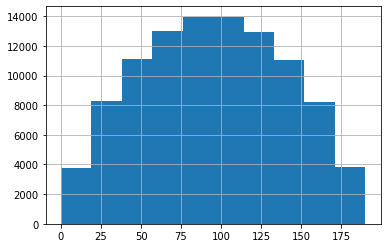

In [6]:
df2.info()
display(df2.head())
print('Пропущенных значений по столбцам:', df2.isna().mean())
print('Дубликатов:', df2.duplicated().mean())
df2['product'].hist()

**Регион 2** Таблица из 100 000 строчек, лишний признак id, пропущенных значений нет, дубликатов нет. Данные в целевом признаке распределены нормально.

In [7]:
df0.drop(['id'], axis = 1, inplace = True)
df1.drop(['id'], axis = 1, inplace = True)
df2.drop(['id'], axis = 1, inplace = True)

Выкинули ненужные столбцы, теперь поделим на features и target

In [8]:
features0 = df0.drop(['product'], axis = 1)
target0 = df0['product']

features1 = df1.drop(['product'], axis = 1)
target1 = df1['product']

features2 = df2.drop(['product'], axis = 1)
target2 = df2['product']

Подготовка данных закончена, теперь можно приступить к обучениям и проверкам моделей

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и первичный осмотр данных проведены хорошо. Согласен, что колонка id нам не нужна.
</div>

## Обучение и проверка модели

Пройдёмся по каждому региону по следующему алгоритму:
- Развика данных на обучающую и валидационную выборку
- Обучение моделей и предсказание
- Проанализируем средний запас предсказанного сырья и RMSE
- Вывод по модели

In [9]:
# Регион 0
features0_train, features0_valid, target0_train, target0_valid = train_test_split(features0, target0,
                                                        test_size = 0.25, random_state = rnd_state)

model0 = LinearRegression()
model0.fit(features0_train, target0_train)
predict0 = model0.predict(features0_valid)

predict0_mean = predict0.mean()
mse0 = mean_squared_error(target0_valid, predict0)
rmse0 = mse0**0.5

print('Средний запас предсказанного сырья:{:.2f}, RMSE = {:.2f}'.format(predict0_mean, rmse0))

Средний запас предсказанного сырья:92.40, RMSE = 37.76


В **Регионе 0** Средний запас предсказанного сырья 92,4. Корень из среднеквадратичного отклонения = 37,76

In [10]:
# Регион 1
features1_train, features1_valid, target1_train, target1_valid = train_test_split(features1, target1,
                                                        test_size = 0.25, random_state = rnd_state)

model1 = LinearRegression()
model1.fit(features1_train, target1_train)
predict1 = model1.predict(features1_valid)

predict1_mean = predict1.mean()
mse1 = mean_squared_error(target1_valid, predict1)
rmse1 = mse1**0.5

print('Средний запас предсказанного сырья:{:.2f}, RMSE = {:.2f}'.format(predict1_mean, rmse1))

Средний запас предсказанного сырья:68.71, RMSE = 0.89


В **Регионе 1** Средний запас предсказанного сырья 68,71 (меньше, чем в нулевом регионе). Корень из среднеквадратичного отклонения = 0,89 (ошибка гораздо меньше, чем в 0 регионе, возможно благодарю распределению значения столбца product по "корзинам")

In [11]:
# Регион 2
features2_train, features2_valid, target2_train, target2_valid = train_test_split(features2, target2,
                                                        test_size = 0.25, random_state = rnd_state)

model2 = LinearRegression()
model2.fit(features2_train, target2_train)
predict2 = model2.predict(features2_valid)

predict2_mean = predict2.mean()
mse2 = mean_squared_error(target2_valid, predict2)
rmse2 = mse2**0.5

print('Средний запас предсказанного сырья:{:.2f}, RMSE = {:.2f}'.format(predict2_mean, rmse2))

Средний запас предсказанного сырья:94.77, RMSE = 40.15


В **Регионе 2** Средний запас предсказанного сырья 94,77 (наибольшее из регионов). Корень из среднеквадратичного отклонения = 40,15 (отклонение также наибольшее)

**Промежуточный вывод:** Из трех регионов сильно выдается регион 1 - в нём средний предсказанный запас меньше почти на 30%, но также меньше и отклонение предсказаний (почти нулевая). Регионы 0 и 2 очень похожи, в них средний запас предсказанного сырья выше, но велико и отклонение! Перейдём к подготовке расчётов прибыли

## Подготовка к расчёту прибыли

Подготовим переменные. нам известно следующее:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [12]:
WELL_FOR_RESEARCH = 500
BEST_WELL = 200
REGION_BUDGET = 10000000000
BARREL_INCOME = 450000
RISK_PROB = 0.025

<div class="alert alert-block alert-info">
<b>Совет: </b> В названиях константных переменных лучше использовать только БОЛЬШИЕ буквы. Это соглашение между программистами.
</div>

Для безубыточности необходимо, чтобы запасы в выбранных скажинах, в среднем, приносили больше, чем бюджет на разработку точек в регионе

In [13]:
no_loss_well = REGION_BUDGET / BEST_WELL / BARREL_INCOME

print('Достаточный объём скважины для безубыточной разработки:', no_loss_well)

Достаточный объём скважины для безубыточной разработки: 111.11111111111111


In [14]:
region = 0
for i in (predict0_mean, predict1_mean, predict2_mean):
    print('Регион', region)
    print('Объём скажины длz безубыточной разработки:', no_loss_well) 
    print('Средний прездсказанный запас в регионе:', i)
    if i > no_loss_well:
        print('Средний запас в скважинах выше, чем необходимый для безубыточности')
    else:
        print('Средний запас в скважинах ниже, чем необходимый для безубыточности')
    region += 1

Регион 0
Объём скажины длz безубыточной разработки: 111.11111111111111
Средний прездсказанный запас в регионе: 92.39879990657768
Средний запас в скважинах ниже, чем необходимый для безубыточности
Регион 1
Объём скажины длz безубыточной разработки: 111.11111111111111
Средний прездсказанный запас в регионе: 68.71287803913764
Средний запас в скважинах ниже, чем необходимый для безубыточности
Регион 2
Объём скажины длz безубыточной разработки: 111.11111111111111
Средний прездсказанный запас в регионе: 94.77102387765939
Средний запас в скважинах ниже, чем необходимый для безубыточности


Во всех регионах средний предсказанный запас скважин меньше, чем необходимый для безубыточности. Это означает, что нам не подойдут 200 случайных скважин, нам точно нужно брать те, чьи запасы выше или равны нужных нам для безубыточности!

<div class="alert alert-block alert-success">
<b>Успех:</b> Точка безубыточности найдена верно, сравнение проведено!
</div>

## Расчёт прибыли и рисков 

Создадим функцию, которая будет считать прибыль по 200 наибольшим точкам региона, а также посчитаем распределение с помощью Bootstrap и найдём среднюю прибыль и доверительный интервал, соответствующий нашему допустимому уровню риска, и риск убытков.

5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


In [15]:
def revenue_count (target, predict):
    target = pd.Series(target).reset_index(drop=True)
    predict = pd.Series(predict).reset_index(drop=True)
    predict_index = predict.sort_values(ascending = False).index
    selected = target[predict_index][:200]
    return selected.sum() * BARREL_INCOME - REGION_BUDGET

Создали функцию для расчёта прибыли, которая берёт на вход фактические значения и предсказанные и возвращает прибыль по топ 200 точкам, согласно предсказаниям. Теперь перейдём к Бутстреп

In [16]:
# Определим Bootstrap как функцию, чтобы вызывать для каждого региона
def bootstrap (target, predict):
    state = np.random.RandomState(rnd_state)
    values = []
    lost = 0
    for i in range(1000):
        target_sample = target.sample(n = WELL_FOR_RESEARCH, random_state = state, replace = True)
        predict_sample = predict[target_sample.index]
        revenue = revenue_count(target_sample, predict_sample)
        values.append(revenue)
        if revenue < 0:
            lost +=1
    values = pd.Series(values)
    mean_rev = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = lost / 1000
    return mean_rev, lower, upper, risk

Функция для Bootstrap расчёта готова, пройдёмся по регионам

In [17]:
# Регион 0
mean_rev0, lower0, upper0, risk0 = bootstrap(target0_valid.reset_index(drop=True), predict0)

print('Регион 0')
print('Средняя предсказанная прибыль:{:.2f}'.format(mean_rev0))
print('95% доверительный интервал от {:.2f} до {:.2f}'.format(lower0, upper0))
if risk0 > RISK_PROB:
    print('Вероятность убытков больше, чем допустимая и равна:{:.1%}'.format(risk0))
else:
    print('Вероятность убытков меньше, чем допустимая и равна:{:.1%}'.format(risk0))

Регион 0
Средняя предсказанная прибыль:399575478.05
95% доверительный интервал от -110467895.33 до 897460327.72
Вероятность убытков больше, чем допустимая и равна:6.0%


***Регион 0 нам не подходит ввиду слишком большой вероятности убытков!***

In [18]:
# Регион 1
mean_rev1, lower1, upper1, risk1 = bootstrap(target1_valid.reset_index(drop=True), predict1)

print('Регион 1')
print('Средняя предсказанная прибыль:{:.2f}'.format(mean_rev1))
print('95% доверительный интервал от {:.2f} до {:.2f}'.format(lower1, upper1))
if risk1 > RISK_PROB:
    print('Вероятность убытков больше, чем допустимая и равна:{:.1%}'.format(risk1))
else:
    print('Вероятность убытков меньше, чем допустимая и равна:{:.1%}'.format(risk1))

Регион 1
Средняя предсказанная прибыль:452048890.91
95% доверительный интервал от 61684479.65 до 845340177.51
Вероятность убытков меньше, чем допустимая и равна:1.5%


***Регион 1 нам подходит, риск убытков меньше допустимого***

In [19]:
# Регион 2
mean_rev2, lower2, upper2, risk2 = bootstrap(target2_valid.reset_index(drop=True), predict2)

print('Регион 2')
print('Средняя предсказанная прибыль:{:.2f}'.format(mean_rev2))
print('95% доверительный интервал от {:.2f} до {:.2f}'.format(lower2, upper2))
if risk2 > RISK_PROB:
    print('Вероятность убытков больше, чем допустимая и равна:{:.1%}'.format(risk2))
else:
    print('Вероятность убытков меньше, чем допустимая и равна:{:.1%}'.format(risk2))

Регион 2
Средняя предсказанная прибыль:375009902.92
95% доверительный интервал от -144766727.30 до 888390403.53
Вероятность убытков больше, чем допустимая и равна:8.0%


***Регион 2 нам не подходит ввиду слишком большой вероятности убытков!***

# Вывод

**Из предложенных регионов нам подходит Регион 1. Только у него процент риска меньше допустимого 2,5% (составляет всего лишь 1,5%), поэтому в 95% доверительном интервале только положительная прибыль. Средняя предсказанная прибыль для этого региона равна 452 048 890,91**